In [22]:
np.set_printoptions(precision=2)

In [1]:
import argparse
from natsort import natsorted
from pathlib import Path
from pathy import Pathy

parser = argparse.ArgumentParser(description='AG training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=16, type=int)
parser.add_argument('-lr', '--learning_rate', type=float, default=2e-4)
parser.add_argument('-t', '--train_steps', type=int, default=1000)
parser.add_argument('--bucket_name', help='GCS bucket name to stream data from')
parser.add_argument('--tpu_name', help='GCP TPU name') # Only used in the script on GCP



### Sample local config
args = parser.parse_args('''
anglesrgb
--train_dataset rgb_ppt/train
--test_dataset rgb_ppt/val
-c
-s GCS
--bucket_name lfp_europe_west4_a
'''.split())

In [2]:
DATA_BASE = 'data/rgb_simple_ppt/'

In [3]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["target"][0] # remove batch dimension

        return pixel_values, target

In [4]:
# Based on the class defined above, we create training and validation datasets.
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder=f'{DATA_BASE}/train', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=f'{DATA_BASE}/val', feature_extractor=feature_extractor, train=False)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [5]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 3120
Number of validation examples: 80


In [6]:
import subprocess 

def dld_model():
    STORAGE_PATH = Pathy(f'gs://{args.bucket_name}')
    command = ["gsutil", "cp", str(STORAGE_PATH/f'saved_models/{args.run_name}'), "saved_models/"]
    
    try:
        subprocess.call(command)
    except:
        print("try this:  ", " ".join(command))
dld_model()

try this:   gsutil cp gs://lfp_europe_west4_a/saved_models/anglesrgb saved_models/


In [7]:
import pytorch_lightning as pl
from transformers import DetrConfig
from lib.DETR import DetrForObjectDetection
import torch

In [8]:
cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}
config = DetrConfig.from_pretrained("facebook/detr-resnet-50", num_labels=len(id2label))
model = DetrForObjectDetection(config)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrTimmConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (act2): ReLU(inplace=True)
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn3): DetrFrozenBatchNorm2d()
              (act3): ReLU(

In [10]:
def load(model):
    state_dict = torch.load(f'saved_models/{args.run_name}', map_location=torch.device(device))
    model.load_state_dict(state_dict)
    
load(model)


In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image, ImageDraw
import math

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def makeRectangle(l, w, theta, offset=(0,0)):
    c, s = math.cos(theta), math.sin(theta)
    rectCoords = [(l/2.0, w/2.0), (l/2.0, -w/2.0), (-l/2.0, -w/2.0), (-l/2.0, w/2.0)]
    return [(c*x-s*y+offset[0], s*x+c*y+offset[1]) for (x,y) in rectCoords]

def plot_results(pil_img, prob, boxes, fills, rotations):
    #plt.figure(figsize=(16,10))
    #plt.imshow(pil_img)
    #ax = plt.gca()
    #colors = COLORS * 100
    draw = ImageDraw.Draw(pil_img, "RGBA")
    for p, (xmin, ymin, xmax, ymax), (r,g,b), (v1,v2) in zip(prob, boxes.tolist(), fills.tolist(), rotations.tolist()):
        w = xmax - xmin
        h = ymax - ymin
#         ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
#                                    fill=False, color=np.array([r,g,b]), linewidth=3))
        A  = np.arctan2(v2,v1)
        vertices = makeRectangle(w, h, A, offset=(xmin+w/2, ymin+h/2))  
        draw.polygon(vertices, outline='red')
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f} - {np.array([r,g,b])}'
        draw.text((vertices[2][0], vertices[2][1]), text, fill='black')
#         ax.text(xmin, ymin, text, fontsize=15,
#                 bbox=dict(facecolor='yellow', alpha=0.5))
#     plt.axis('off')
#     plt.show()
    return pil_img

In [12]:
def get_preds(image, outputs, threshold):
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # convert predicted boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
    fills = outputs.pred_fill[0, keep].cpu()
    rotations = outputs.pred_rotation[0, keep].cpu()
    return probas, keep, bboxes_scaled, fills, rotations

In [13]:
def visualize_predictions(image, outputs, threshold=0.6):
  # keep only predictions with confidence >= threshold
  
    probas, keep, bboxes_scaled, fills, rotations = get_preds(image, outputs, threshold)
    # plot results
    plot_results(image, probas[keep], bboxes_scaled, fills, rotations)

In [14]:
import win32com.client
from lib.ppt_interface import PPT_shapes, write_slide
import random
Application = win32com.client.Dispatch('PowerPoint.Application')
shape_manager = PPT_shapes()

def get_readout(image, outputs, threshold=0.8):
    probas, keep, bboxes_scaled, fills, rotations = get_preds(image, outputs, threshold)
    prob = probas[keep]
    readout = []
    for p, (xmin, ymin, xmax, ymax), (r,g,b), (v1,v2) in zip(prob, bboxes_scaled.tolist(), fills.tolist(), rotations.tolist()):
            x,y, w, h = xmin, ymin, xmax - xmin, ymax - ymin
            cl = p.argmax()
            read = {
                'name': id2label[cl.item()],
                'left': x,
                'top':y,
                'width': w,
                'height':h,
                'fillRGB': [r,g,b],
                'rotation': np.arctan2(v2,v1)
            }
            readout.append(read)
    return readout



In [15]:
pixel_values, target = val_dataset[9]
pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)
# forward pass to get class logits and bounding boxes
outputs = model(pixel_values=pixel_values, pixel_mask=None)

torch.Size([1, 3, 750, 1333])


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\ProgramData\Anaconda3\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


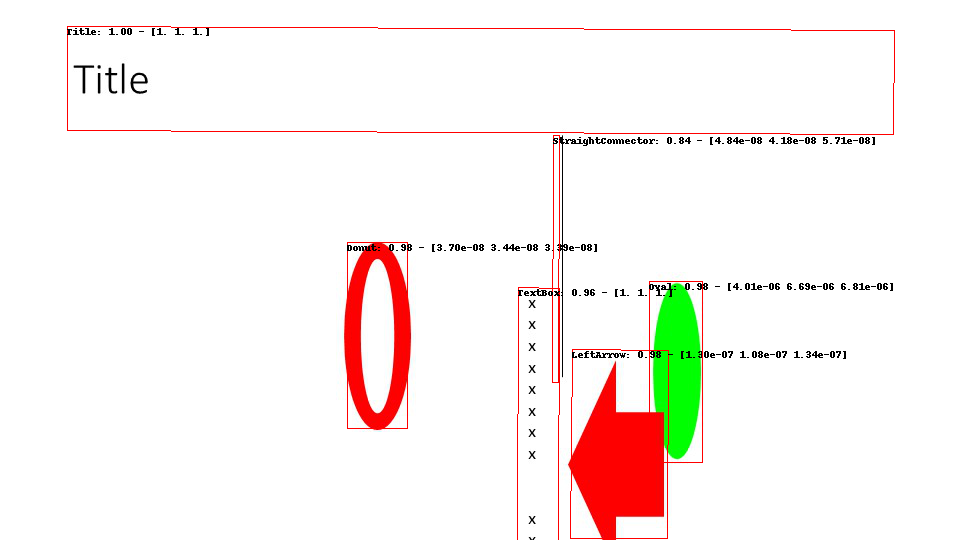

In [24]:
image_id = target['image_id'].item()
image = val_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{DATA_BASE}/val', image['file_name']))

img = visualize_predictions(image, outputs)
image

In [19]:
val_dataset.coco.imgToAnns[9]

[{'id': 74,
  'image_id': 9,
  'category_id': 0,
  'iscrowd': 0,
  'area': 86422.53158569336,
  'bbox': [66.0, 28.75, 828.0, 104.37503814697266],
  'segmentation': [],
  'angle': 0.0,
  'rotation': [1.0, 0.0],
  'fill': [1.0, 1.0, 1.0]},
 {'id': 75,
  'image_id': 9,
  'category_id': 1,
  'iscrowd': 0,
  'area': 18105.059098228812,
  'bbox': [520.9722290039062,
   287.4635314941406,
   29.29732322692871,
   617.9765625],
  'segmentation': [],
  'angle': 0.0,
  'rotation': [1.0, 0.0],
  'fill': [1.0, 1.0, 1.0]},
 {'id': 76,
  'image_id': 9,
  'category_id': 6,
  'iscrowd': 0,
  'area': 8457.770312875276,
  'bbox': [652.5560913085938,
   283.0004577636719,
   48.005985260009766,
   176.18157958984375],
  'segmentation': [],
  'angle': 0.0,
  'rotation': [1.0, 0.0],
  'fill': [0.0, 1.0, 0.0]},
 {'id': 77,
  'image_id': 9,
  'category_id': 7,
  'iscrowd': 0,
  'area': 12576.444551141001,
  'bbox': [343.7273864746094,
   241.77346801757812,
   66.83157348632812,
   188.18118286132812],
  'se

In [41]:
Presentation = Application.Presentations.Add()

In [109]:
readout = get_readout(image, outputs, threshold=0.6)
write_slide(readout, Presentation, shape_manager)

In [ ]:
Presentation.close()